<a href="https://colab.research.google.com/github/InbalBolshinsky/multi-modal-mutation-detector/blob/main/Multi-Modal_Mutation_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the VCF file from ClinVar and extracting it.

In [2]:
!wget ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz

--2024-12-13 13:55:20--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
           => ‘clinvar.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh38 ... done.
==> SIZE clinvar.vcf.gz ... 104979789
==> PASV ... done.    ==> RETR clinvar.vcf.gz ... done.
Length: 104979789 (100M) (unauthoritative)

clinvar.vcf.gz      100%[===================>] 100.12M  52.6MB/s    in 1.9s    

2024-12-13 13:55:23 (52.6 MB/s) - ‘clinvar.vcf.gz’ saved [104979789]



In [3]:
!gunzip clinvar.vcf.gz

Viewing clinvar.vcf head:

In [4]:
!grep "CLNDN=" clinvar.vcf | head

1	69134	2205837	A	G	.	.	ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69134A>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Likely_benign;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69314	3205580	T	G	.	.	ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69314T>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69423	3205581	G	A	.	.	ALLELEID=3374048;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69423G>A;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69581	2252161	C	G	.	.	ALLELEID=2238986;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CL

Automate Complex Filtering:

In [5]:
# Parse VCF file and filter for specific conditions
!pip install pysam
import pysam
# Save each DataFrame to a CSV file (optional) and print the counts
import os

# Open the VCF file
vcf_file = pysam.VariantFile("clinvar.vcf")
filtered_variants = []
import pandas as pd

# Load the VCF data into a DataFrame (update the path to your filtered VCF file)
vcf_file = "clinvar.vcf"  # Replace with the actual file path
columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
# Specify dtype for the CHROM column to suppress the warning and potentially improve performance
df = pd.read_csv(vcf_file, sep="\t", comment='#', names=columns, dtype={'CHROM': str}, low_memory=False) # Adding dtype={'CHROM': str} and low_memory=False

# Function to parse INFO field into a dictionary
def parse_info(info):
    parsed = {}
    for entry in info.split(";"):
        if "=" in entry:
            key, value = entry.split("=", 1)
            parsed[key] = value
    return parsed

# Parse the INFO column into separate fields
info_parsed = df["INFO"].apply(parse_info)
info_df = pd.DataFrame(info_parsed.tolist())
df = pd.concat([df, info_df], axis=1)

# Filter for relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

# Create DataFrames for each gene and classification combination
result_dfs = {}
for gene in genes_of_interest:
    for classification_name, classification_values in classifications.items():
        # Filter for the specific gene and classification
        filtered_df = df[
            (df["GENEINFO"].str.contains(gene, na=False)) &
            (df["CLNSIG"].isin(classification_values))
        ]
        # Store the filtered DataFrame in a dictionary
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        result_dfs[key] = filtered_df

# Save each DataFrame to a CSV file
for key, filtered_df in result_dfs.items():
    # Define the output directory
    output_dir = "filtered_variants"  # Or any directory name you prefer
    # Create the full file path
    file_path = os.path.join(output_dir, f"{key}.csv")
    # Create the directory (including parent directories)
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    # Save the DataFrame to CSV
    filtered_df.to_csv(file_path, index=False)

EGFR_Pathogenic/Likely_Pathogenic: 119 variants
EGFR_Benign/Likely_Benign: 1292 variants
EGFR_VUS: 1409 variants
KRAS_Pathogenic/Likely_Pathogenic: 62 variants
KRAS_Benign/Likely_Benign: 146 variants
KRAS_VUS: 198 variants
ALK_Pathogenic/Likely_Pathogenic: 131 variants
ALK_Benign/Likely_Benign: 2458 variants
ALK_VUS: 3432 variants


In [6]:
for key, filtered_df in result_dfs.items():
    print(f"{key}: {len(filtered_df)} variants")


EGFR_Pathogenic/Likely_Pathogenic: 119 variants
EGFR_Benign/Likely_Benign: 1292 variants
EGFR_VUS: 1409 variants
KRAS_Pathogenic/Likely_Pathogenic: 62 variants
KRAS_Benign/Likely_Benign: 146 variants
KRAS_VUS: 198 variants
ALK_Pathogenic/Likely_Pathogenic: 131 variants
ALK_Benign/Likely_Benign: 2458 variants
ALK_VUS: 3432 variants


In [7]:
filtered_df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,ALLELEID,CLNDISDB,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
267643,2,283118,3286740,T,G,.,.,ALLELEID=3451611;CLNDISDB=MedGen:CN169374;CLND...,3451611,MedGen:CN169374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267644,2,286153,2551227,G,A,.,.,ALLELEID=2721522;CLNDISDB=MedGen:CN169374;CLND...,2721522,MedGen:CN169374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267645,2,286296,3111557,G,T,.,.,ALLELEID=3268232;CLNDISDB=MedGen:CN169374;CLND...,3268232,MedGen:CN169374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267646,2,286312,3111555,G,C,.,.,ALLELEID=3268230;CLNDISDB=MedGen:CN169374;CLND...,3268230,MedGen:CN169374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267647,2,287612,2539325,C,G,.,.,ALLELEID=2708303;CLNDISDB=MedGen:CN169374;CLND...,2708303,MedGen:CN169374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


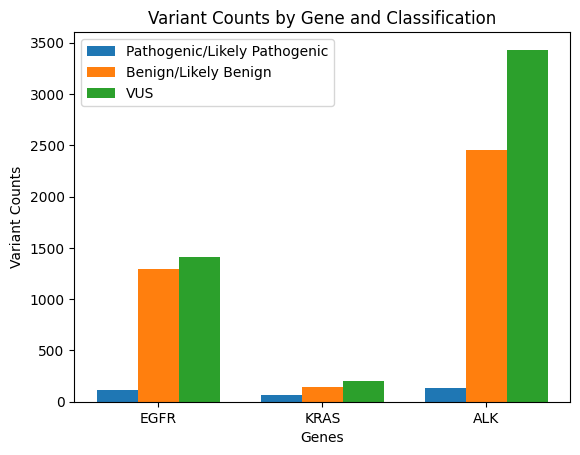

In [8]:
import matplotlib.pyplot as plt

# Data for visualization
genes = ["EGFR", "KRAS", "ALK"]
pathogenic_counts = [119, 62, 131]
benign_counts = [1292, 146, 2458]
vus_counts = [1409, 198, 3432]

# Plotting
bar_width = 0.25
x = range(len(genes))

plt.bar(x, pathogenic_counts, width=bar_width, label="Pathogenic/Likely Pathogenic")
plt.bar([p + bar_width for p in x], benign_counts, width=bar_width, label="Benign/Likely Benign")
plt.bar([p + 2 * bar_width for p in x], vus_counts, width=bar_width, label="VUS")

plt.xticks([p + bar_width for p in x], genes)
plt.xlabel("Genes")
plt.ylabel("Variant Counts")
plt.title("Variant Counts by Gene and Classification")
plt.legend()
plt.show()